In [1]:
import math

In [2]:
import pipe_pytools.polar_plot as pp
import pipe_pytools.tools as tl
import pipe_pytools.grid as gr

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
t,dt,Dp,Re,Xmax,epsr,lx,Jm,lt,nsym,vel = tl.get_scp("lin0.scp")

In [8]:
vel /= (vel.max() * 21)

In [9]:
x = gr.X(2**lx, Xmax)
r = gr.R(Jm, epsr)
th = gr.Th(2**lt, nsym)

In [10]:
Im = x.m
hx = x.h
yt = r.f
yt1 = r.f1
rt = r.n
rt1 = r.n1
Km = th.m
ht = th.h

In [11]:
def bc(vel):
    u,v,w = vel
        
    vel[:,:,:,0] = vel[:,:,:,-2]
    vel[:,:,:,-1] = vel[:,:,:,1]
    
    for i in range(0,Im+1):
        for j in range(1,Jm+1):
            u.T[i,j,0] = u.T[i,j,1]
            u.T[i,j,Km+1] = u.T[i,j,Km]
            
        for k in range(1,Km+1):
            u.T[i,Jm+1,k] = - u.T[i,Jm,k]
            
    for k in range(1,Km+1):
        for i in range(1,Im+1):
            v.T[i,Jm,k] = 0.0
            
    for j in range(1,Jm+1):
        for i in range(1,Im+1):
            v.T[i,j,0] = v.T[i,j,1]
            v.T[i,j,Km+1] = v.T[i,j,Km]
            
    for j in range(1,Jm+1):
        for i in range(0,Im+2):
            w.T[i,j,0] = 0.0
            w.T[i,j,Km] = 0.0
            
    for k in range(0,Km+1):
        for i in range(1,Im+1):
            w.T[i,Jm+1,k] = - w.T[i,Jm,k] * yt[Jm] / yt[Jm+1]
            
    return vel

In [12]:
def rot(vel):
    bc(vel)
    u,v,w = vel
    
    om = np.zeros((3,Km+2,Jm+2,Im+2))
    ox,on,ot = om
    
    for i in range(1,Im+1):
        for j in range(1,Jm+1):
            for k in range(0,Km+1):
                w0 = w.T[i,j,k]
                w1 = w.T[i,j+1,k]
                v0 = v.T[i,j,k]
                v1 = v.T[i,j,k+1]
                ox.T[i,j,k] = ((yt[j+1]*w1 - yt[j]*w0) / rt1[j] - (v1 - v0) / ht) / rt[j]
                
        for j in range(0,1):
            for k in range(0,Km+1):
                ox.T[i,j,k] = 0.0
                
    for k in range(0,Km+1):
        for j in range(1,Jm+1):
            for i in range(0,Im+1):
                u0 = u.T[i,j,k]
                u1 = u.T[i,j,k+1]
                w0 = w.T[i,j,k]
                w1 = w.T[i+1,j,k]
                on.T[i,j,k] = (u1 - u0) / (yt[j] * ht) - (w1 - w0) / hx
                
    for k in range(1,Km+1):
        for j in range(1,Jm+1):
            for i in range(0,Im+1):
                u0 = u.T[i,j,k]
                u1 = u.T[i,j+1,k]
                v0 = v.T[i,j,k]
                v1 = v.T[i+1,j,k]
                ot.T[i,j,k] = (v1 - v0) / hx - (u1 - u0) / rt1[j]
    
    return om

In [13]:
def nonlin(vel,om):
    u,v,w = vel
    ox,on,ot = om
    velt = np.zeros((3,Km+2,Jm+2,Im+2))
    ut,vt,wt = velt
    
    for i in range(1,Im+1):
        for j in range(1,Jm+1):
            for k in range(1,Km+1):
                v0 = 0.5 * (v.T[i,j-1,k] + v.T[i+1,j-1,k])
                v1 = 0.5 * (v.T[i,j,k] + v.T[i+1,j,k])
                ot0 = rt[j-1] * rt1[j-1] * ot.T[i,j-1,k]
                ot1 = rt[j] * rt1[j] * ot.T[i,j,k]
                w0 = 0.5 * (w.T[i,j,k-1] + w.T[i+1,j,k-1])
                w1 = 0.5 * (w.T[i,j,k] + w.T[i+1,j,k])
                or0 = on.T[i,j,k-1]
                or1 = on.T[i,j,k]
                ut.T[i,j,k] = 0.5 * ((v0*ot0 + v1*ot1) / (yt[j] * yt1[j]) - (w0*or0 + w1*or1))
        
    for k in range(1,Km+1):
        for i in range(1,Im+1):
            for j in range(1,Jm):
                w0 = 0.5 * (w.T[i,j,k-1] + w.T[i,j+1,k-1])
                w1 = 0.5 * (w.T[i,j,k] + w.T[i,j+1,k])
                ox0 = ox.T[i,j,k-1]
                ox1 = ox.T[i,j,k]
                u0 = 0.5 * (u.T[i-1,j,k] + u.T[i-1,j+1,k])
                u1 = 0.5 * (u.T[i,j,k] + u.T[i,j+1,k])
                ot0 = ot.T[i-1,j,k]
                ot1 = ot.T[i,j,k]
                vt.T[i,j,k] = 0.5 * ((w0*ox0 + w1*ox1) - (u0*ot0 + u1*ot1))
        
            vt.T[i,Jm,k] = 0.0
            
    for k in range(1,Km+1):
        for j in range(1,Jm+1):
            for i in range(1,Im+1):
                u0 = 0.5 * (u.T[i-1,j,k] + u.T[i-1,j,k+1])
                u1 = 0.5 * (u.T[i,j,k] + u.T[i,j,k+1])
                or0 = on.T[i-1,j,k]
                or1 = on.T[i,j,k]
                v0 = 0.5 * (v.T[i,j-1,k] + v.T[i,j-1,k+1])
                v1 = 0.5 * (v.T[i,j,k] + v.T[i,j,k+1])
                ox0 = rt[j-1] * rt1[j-1] * ox.T[i,j-1,k]
                ox1 = rt[j] * rt1[j] * ox.T[i,j,k]
                wt.T[i,j,k] = 0.5 * ((u0*or0 + u1*or1) - (v0*ox0 + v1*ox1) / (yt[j] * yt1[j]))
                
    return velt

In [14]:
om = rot(vel)

In [15]:
u,v,w = vel
ox,on,ot = om

In [16]:
nl = rot(nonlin(vel,om))[0]

In [22]:
cwx = np.zeros_like(u)

for k in range(1,Km+1):
    for j in range(1,Jm+1):
        for i in range(1,Im+1):
            cwx[k,j,i] = -(w[k+1,j,i]*ox[k+1,j,i] - w[k,j,i]*ox[k,j,i]) / (rt[j] * ht)

In [37]:
cvx = np.zeros_like(u)

for k in range(1,Km+1):
    for j in range(1,Jm+1):
        for i in range(1,Im+1):
            cvx[k,j,i] = -(yt[j+1]*v[k,j+1,i]*ox[k,j+1,i] - yt[j]*v[k,j,i]*ox[k,j,i]) / (rt1[j]*rt[j])

In [38]:
cux = np.zeros_like(ox)

for k in range(1,Km+1):
    for j in range(1,Jm+1):
        for i in range(1,Im+1):
            cux[k,j,i] = -(u[k,j,i+1]*ox[k,j,i+1] - u[k,j,i]*ox[k,j,i]) / hx

In [39]:
cx = cwx+cvx+cux

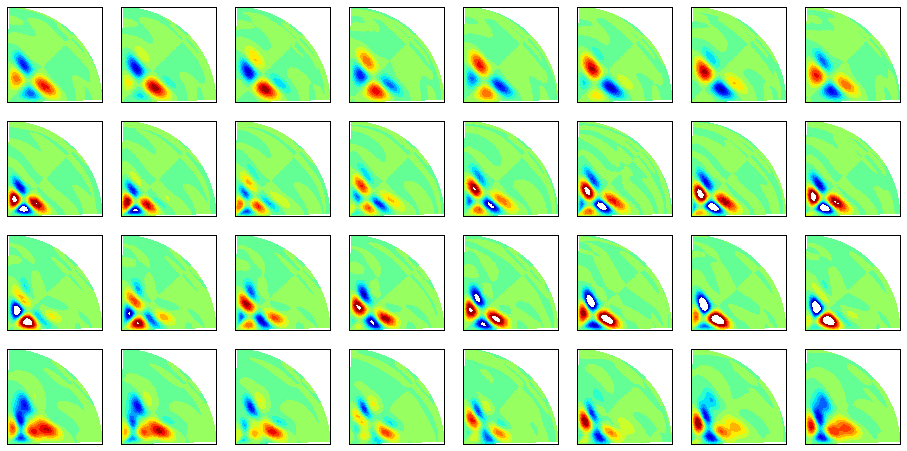

In [40]:
plt.figure(figsize=(16,16))
n = 1

for ii in range(1,33,4):
    plt.subplot(8,8,n)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], cux[1:-1,1:-1,ii], (-0.006,0.006))
    n+=1

for ii in range(1,33,4):
    plt.subplot(8,8,n)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], cvx[1:-1,1:-1,ii], (-0.006,0.006))
    n+=1

for ii in range(1,33,4):
    plt.subplot(8,8,n)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], cwx[1:-1,1:-1,ii], (-0.006,0.006))
    n+=1

for ii in range(1,33,4):
    plt.subplot(8,8,n)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], cx[1:-1,1:-1,ii], (-0.006,0.006))
    n+=1


In [32]:
dwx = np.zeros_like(u)

for k in range(1,Km+1):
    for j in range(1,Jm+1):
        for i in range(1,Im+1):
            dwx[k,j,i] = -(ot[k+1,j,i]*u[k+1,j,i] - ot[k,j,i]*u[k,j,i]) / (rt[j] * ht)

In [41]:
dvx = np.zeros_like(u)

for k in range(1,Km+1):
    for j in range(1,Jm+1):
        for i in range(1,Im+1):
            dvx[k,j,i] = -(yt[j+1]*on[k,j+1,i]*u[k,j+1,i] - yt[j]*on[k,j,i]*u[k,j,i]) / (rt1[j]*rt[j])

In [42]:
dux = np.zeros_like(ox)

for k in range(1,Km+1):
    for j in range(1,Jm+1):
        for i in range(1,Im+1):
            dux[k,j,i] = -(u[k,j,i+1]*ox[k,j,i+1] - u[k,j,i]*ox[k,j,i]) / hx

In [43]:
dx= dux+dvx+dwx

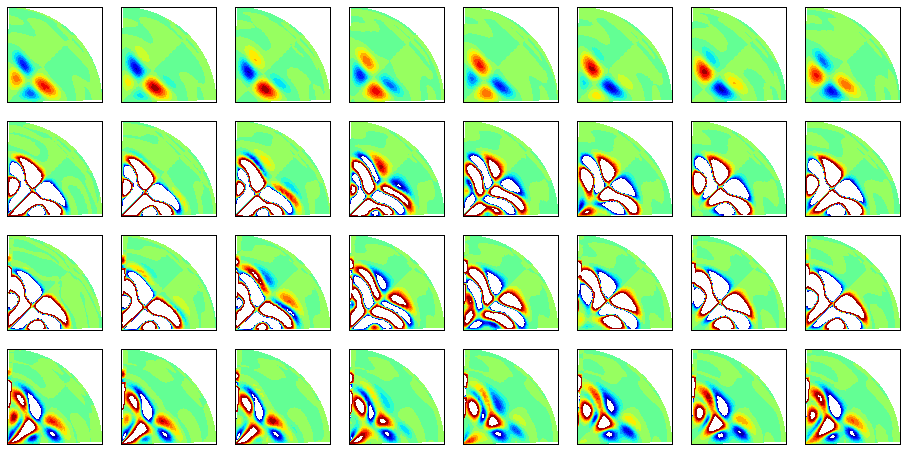

In [44]:
plt.figure(figsize=(16,16))
n = 1

for ii in range(1,33,4):
    plt.subplot(8,8,n)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], dux[1:-1,1:-1,ii], (-0.006,0.006))
    n+=1

for ii in range(1,33,4):
    plt.subplot(8,8,n)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], dvx[1:-1,1:-1,ii], (-0.006,0.006))
    n+=1

for ii in range(3,33,4):
    plt.subplot(8,8,n)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], dwx[1:-1,1:-1,ii], (-0.006,0.006))
    n+=1

for ii in range(3,33,4):
    plt.subplot(8,8,n)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], dx[1:-1,1:-1,ii], (-0.006,0.006))
    n+=1